# EXP11 주식 예측에 도전 해보자!


* 이번 시간엔 시계열 데이터의 정의와, 시계열 데이터셋을 가지고 안정적 여부를 체크 해 보기도 하고, 불안정한 데이터를 로그화 시켜 데이터를 안정적으로 바꿔 augmented_dickey_fuller_test 를 수행 해보았다. 


* 이를 토대로, 실제 주식 예측에 도전해 보는 프로젝트를 진행 해 보겠다. 




---




# 루브릭 평가 기준 


| 평가문항 | 상세기준 |
| :---: | :---: |
| 1. 시계열의 안정성이 충분히 확인되었는가? | 플로팅과 adfuller 메소드가 모두 적절히 사용되었음 |
| 2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가? | p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨 |
| 3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가? | 3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨 |



----




# 목차 


## 1. 필요한 데이터 가져오기, 디렉토리 생성

## 2. 시계열 데이터 준비하기 

## 3. 데이터 전처리 수행하기

## 4. 시계열 안정성 분석하기 

## 5. 학습, 테스트 데이터셋 생성하기

## 6. 적정 ARIMA 모수 찾기

## 7. ARIMA 모델 훈련과 테스트

## 8. 다른 주식 종목 예측 해보기 (2개 더!)



----




# 1. 필요한 데이터 가져오기, 디렉토리 생성



## &nbsp;&nbsp;1-1 데이터셋 다운받기 


* 이번 exp에선 주식값 예측이므로, [Yahoo Finance](https://finance.yahoo.com/) 에서 사용할 데이터셋을 다운받아 줍니다.   

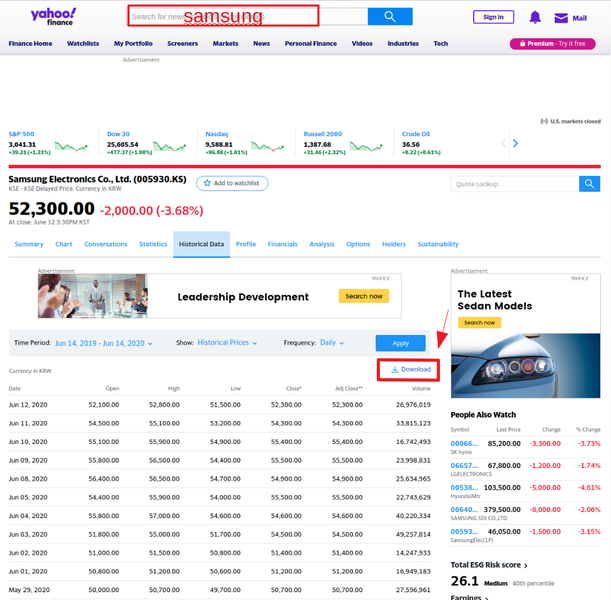

* 3개 이상 종목을 분석 해야 하므로 3개 기업에 대한 데이터를 다운받아 줍니다.
    * NVDA.csv - Ndivia 
    * MSFT.csv - 마이크로소프트
    * AAPL.csv - 애플 
* 다운 받은 csv 파일은 ```stock_prediction/data```에 올려줍니다. 


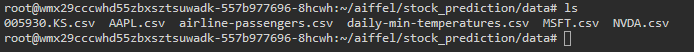  
* 제대로 들어가 있는지도 한번 확인 해 줍니다:) 


## &nbsp;&nbsp; 1-2 필요한 라이브러리 불러오기

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore') #경고 무시

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


print('라이브러리 불러오기 성공!')

라이브러리 불러오기 성공!


## &nbsp;&nbsp; 1-3 필요한 함수 모음


* 프로젝트 진행에 필요한 함수를 모았습니다. 

* adfuller 메소드를 이용해 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 함수. 

* p-value를 확인 할 수 있습니다. 

In [32]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    

* 구간 통계치를 시각화 해 보는 함수 

In [33]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)



---




# 2. 시계열 데이터 준비하기


* 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
* 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
* 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)


* Yahoo Finance 에서 다운 받아, 저장한 주식 csv 파일을 불러옵니다. 
* 우선 apple의 02.16 기준 주식값 데이터를 가져오겠습니다

In [34]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/NVDA.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2021-02-16    153.302505
2021-02-17    149.059998
2021-02-18    148.289993
2021-02-19    149.264999
2021-02-22    143.557495
Name: Close, dtype: float64




----




# 3. 데이터 전처리 수행하기


* 불러온 데이터를 모델 학습에 알맞게 가공해줍니다.
    - 결측치를 처리
    - 안정적인 시계열 데이터로 바꿔주기 위해 로그 변환 시도.

## &nbsp;&nbsp; 3-1 데이터 결측치 처리


In [35]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 


Series([], Name: Close, dtype: float64)

## &nbsp;&nbsp; 3-2 로그 변환 


* 시계열 데이터를 안정적으로 바꿔주기위해 바꿔줍니다. 

In [36]:
# 로그 변환 시도 
ts_log = np.log(ts)




-----




# 4. 시계열 안정성 분석하기


* 안정적이지 않은 시계열을 분석하기 위해선 안정적인 시계열로 변환하는 과정이 필요하다.
* 방법은 2가지 
    - 방법 1.
        - 정성적인 분석을 통해 보다 안정적(starionary)인 특성을 가지도록 
          **기존의 시계열 데이터를 가공/변형**하는 시도
    - 방법 2.
        - **시계열 분해(Time series decomposition)** 기법을 적용



* 이번 파트에선 아래의 방법으로 데이터를 분석해보고 안정성을 확인해본다.
    - 정성적 그래프 분석
    - 정량적 Augmented Dicky-Fuller Test
    - 시계열 분해(Time Series Decomposition)
    - Residual 안정성 확인

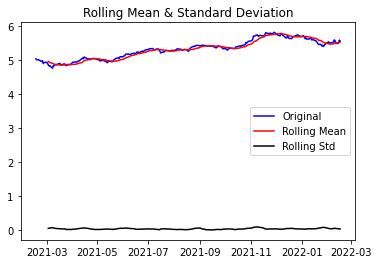

Results of Dickey-Fuller Test:
Test Statistic                  -0.914126
p-value                          0.783285
#Lags Used                       0.000000
Number of Observations Used    254.000000
Critical Value (1%)             -3.456360
Critical Value (5%)             -2.872987
Critical Value (10%)            -2.572870
dtype: float64


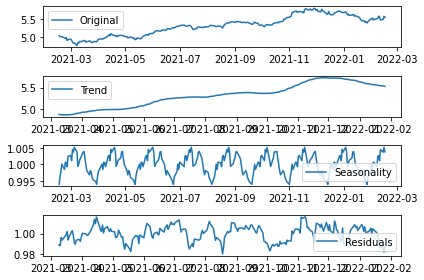

In [37]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [38]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.607685
p-value                          0.000125
#Lags Used                       6.000000
Number of Observations Used    218.000000
Critical Value (1%)             -3.460708
Critical Value (5%)             -2.874891
Critical Value (10%)            -2.573886
dtype: float64


* p-value로 보아 안정적인 시계열이 얻어진 것 같다! 




----




# 5. 학습, 테스트 데이터셋 생성하기


- 학습 데이터와 테스트 데이터를 분리합니다.
- 분리 비율은 학습 : test = 9 : 1
- 시계열 예측인 만큼 가장 나중 데이터를 테스트용으로 사용하는것이 타당하다.
    - 미래를 예측하는? 이후 결과를 예측하는 모델을 만들꺼니깐?
   

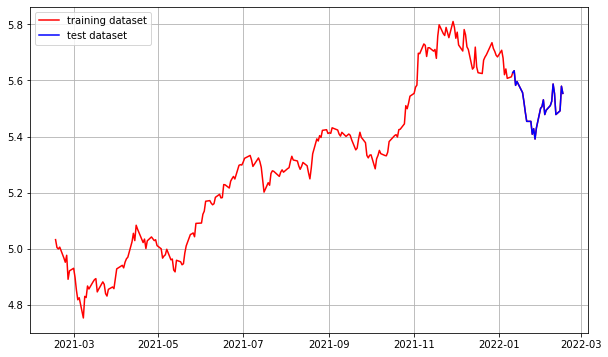

In [39]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [40]:
#데이터셋의 형태를 확인 해 봅니다.
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2021-02-16    5.032413
2021-02-17    5.004349
Name: Close, dtype: float64
(229,)
(26,)





-----





# 6. 적정 ARIMA 모수 찾기


- `ARIMA` 를 효과적으로 활용하기 위해서는 `**ARIMA`의 모수(parameter)를 잘 설정해야** 합니다
    - `p` : 자기회귀 모형(AR)의 시차
    - `d` : 차분 누적(I) 횟수
    - `q` : 이동평균 모형(MA)의 시차
    
    
- `p` 와 `q` 는 일반적으로 `p + q < 2`, `p * q = 0`인 값을 사용함.
    - 이는 `p` 나 `q` 중 하나는 0이라는 뜻
    - 많은 시계열 데이터가 `AR`이나 `MA` 중 하나의 경향만 가지기 때문에.
    

* ACF, PACF 그려보기 -> p,q 구하기
* 차분 안정성 확인 -> d 구하기

## &nbsp;&nbsp; 6-1 p,q 값 구하기 


* ACF, PACF를 그려 p와 q값을 구해봅시다. 


* ACF(Autocorrelation Function)
    - 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수


* PACF(Partial Autocorrelation Function)
    - 다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함수

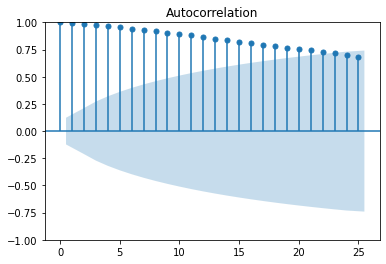

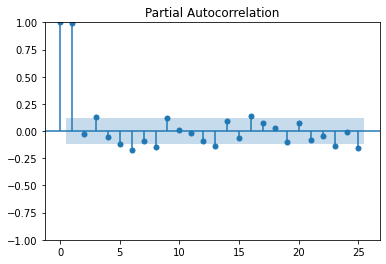

In [41]:
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


* lms 노드 기준으로 보고 분석해 봤을 때, 
* p 값 = 1이 적합한것으로 보인다. 
   -  p값이 2 이상인 구간에선 pacf가 거의 0에 가까워지고 있기 때문에? 
   
* ACF는 점차적으로 감소하고있음. 
* `ma`를 고려하지 않을것이기 때문에 q=0으로 두고 해 보겠습니다. 

## &nbsp;&nbsp; 6-2 d 값 구하기 


* d  값은 차분 안정성을 확인하여 구해볼 수 있습니다.


* **차분** 
    - 계절성 패턴을 상쇄하기 위한 방법
    - 시계열을 한 스텝 앞으로 시프트한 시계열을 원래 시계열에 빼 주는 방법.
    - 이렇게 되면 남은 것은 현재 스텝 값 - 직전 스텝 값이 되어 정확히 **이번 스텝에서 발생한 변화량을 의미**하게 됩니다.
    
    
* d 차 차분을 구해보고, 이때 시계열이 안정된 상태인지를 확인 해봐야 한다합니다. 
* 1차, 2차 차분을 구해보겠습니다. 

Results of Dickey-Fuller Test:
Test Statistic                  -5.059862
p-value                          0.000017
#Lags Used                       5.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


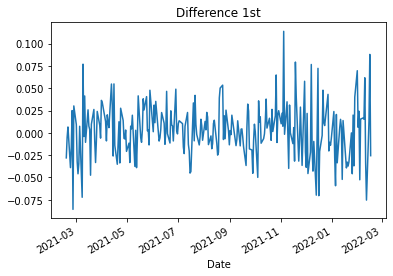

In [42]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.410291e+01
p-value                        2.599688e-26
#Lags Used                     4.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


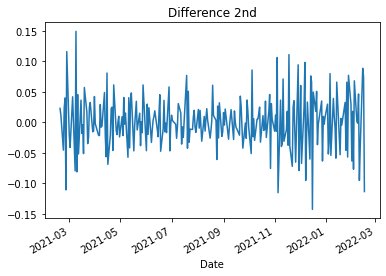

In [43]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

* 1차 차분을 했을 때 보다 2차 차분을 했을 때가 그래프가 조금더 안정적으로 보인다. 
* d 값은 2로 결정! 

==>

### p값 : 1 , q값 : 0, d:값 2 로 주고 모델을 훈련하고 가격을 예측해 보겠습니다. 




-----




# 7. ARIMA 모델 훈련과 테스트


* 이전 단계에서 가공한 데이터셋과 p, q, d값을 가지고 ARIMA 모델을 훈련해보고, 모델의 정확도까지 측정 해 보겠습니다.
    
    
    
    * ARIMA 모델 빌드와 훈련
    * 모델 테스트 및 플로팅
    * 최종 예측 모델 정확도 측정(MAPE)

## &nbsp;&nbsp; 7-1 ARIMA 모델 빌드와 훈련

In [44]:

# Build Model
model = ARIMA(train_data, order=(1, 0, 2))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  229
Model:                 ARIMA(1, 0, 2)   Log Likelihood                 487.521
Date:                Thu, 17 Feb 2022   AIC                           -965.041
Time:                        06:16:21   BIC                           -947.873
Sample:                             0   HQIC                          -958.115
                                - 229                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2909      0.244     21.668      0.000       4.812       5.770
ar.L1          0.9954      0.006    171.465      0.000       0.984       1.007
ma.L1         -0.0535      0.067     -0.800      0.4

## &nbsp;&nbsp; 7-2 모델 테스트 및 플로팅

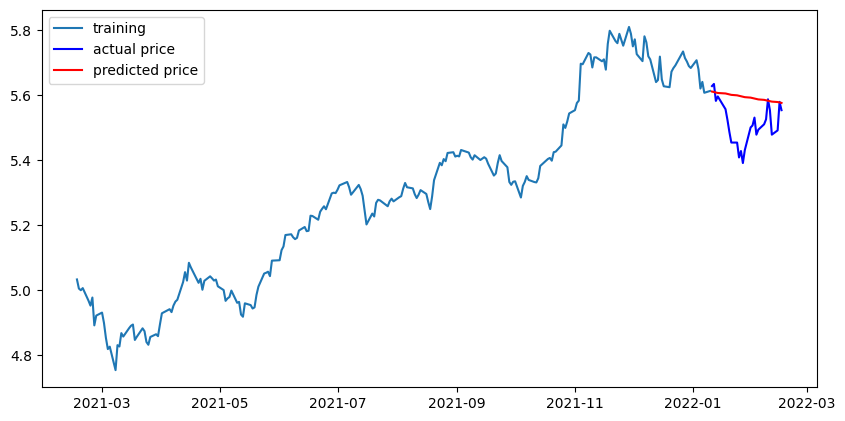

In [45]:

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

## &nbsp;&nbsp; 7-3 최종 예측 모델 정확도 측정(MAPE)

In [47]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  646.0156876761291
MAE:  21.011862547284814
RMSE:  25.41683866408506
MAPE: 8.84%





-----





# 8. 다른 주식 종목 예측 해보기 (2개 더!)


* 지금까지 진행했던 과정을 가지고, 다른 주식 종목 2종을 예측해 봅시다. 
* 준서님의 도움을 받아, 위의 과정을 함수화 해, 새 주피터 노트북 파일에 옮겨두었습니다. 
* py 파일로 저장해 라이브러리로 사용할 수 있게 만들어주었습니다. (참고페이지)
* 새 노트북 파일에 만들어준 함수를 가져와, 두 주식에 관한 예측도 해 봅시다! 


* 위 과정에선 NVIDIA의 주식 데이터를 사용 해 봤으니, APPLE과 마이크로소프트사의 주식 데이터를 확인 해보겠습니다.

## &nbsp;&nbsp; 8-1 함수 불러오기 


* exp11my_f 라이브러리엔 
    1. 데이터 불러오기, 전처리 과정을 수행 할 data_ready 
    2. 불러온 데이터를 가지고 모델을 학습하고, 주식을 예측해 보는 result_gap 
    가 있습니다.

In [2]:
import exp11my_f as mf

## &nbsp;&nbsp; 8-2 APPLE 사의 주식 데이터 예측


정성적 그래프 분석


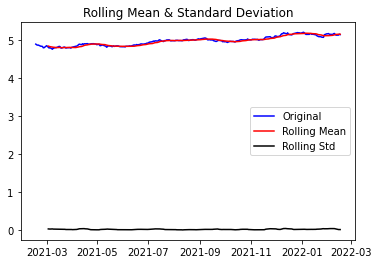

------------------------------
정량적 Augmented Dicky-Fuller Test
Results of Dickey-Fuller Test:
Test Statistic                  -0.691867
p-value                          0.848845
#Lags Used                       0.000000
Number of Observations Used    254.000000
Critical Value (1%)             -3.456360
Critical Value (5%)             -2.872987
Critical Value (10%)            -2.572870
dtype: float64
------------------------------
Results of Dickey-Fuller Test:
Test Statistic                  -4.543630
p-value                          0.000164
#Lags Used                       0.000000
Number of Observations Used    224.000000
Critical Value (1%)             -3.459885
Critical Value (5%)             -2.874531
Critical Value (10%)            -2.573694
dtype: float64
------------------------------


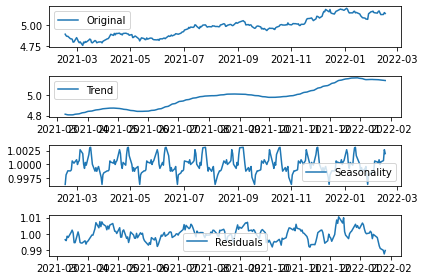

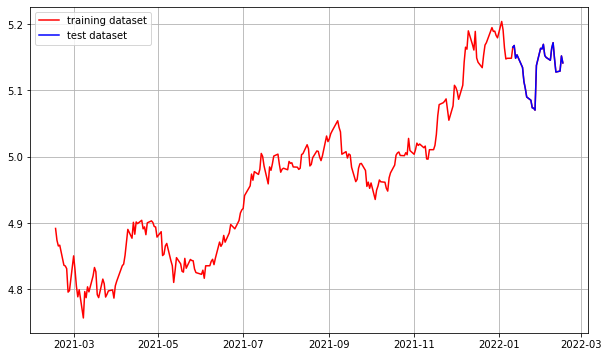

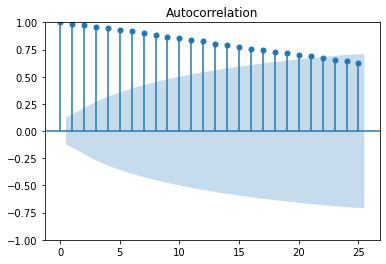

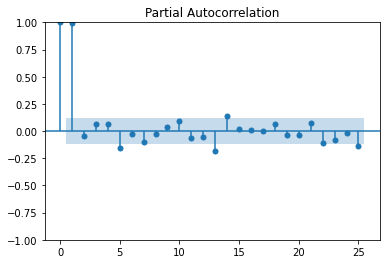

------------------------------
 1차 차분 구하기 
Results of Dickey-Fuller Test:
Test Statistic                -1.618310e+01
p-value                        4.246272e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.530000e+02
Critical Value (1%)           -3.456464e+00
Critical Value (5%)           -2.873033e+00
Critical Value (10%)          -2.572895e+00
dtype: float64
------------------------------
 2차 차분 구하기 
Results of Dickey-Fuller Test:
Test Statistic                -7.628856e+00
p-value                        2.034090e-11
#Lags Used                     1.300000e+01
Number of Observations Used    2.390000e+02
Critical Value (1%)           -3.458011e+00
Critical Value (5%)           -2.873710e+00
Critical Value (10%)          -2.573256e+00
dtype: float64


In [3]:
train_data, test_data = mf.data_ready('AAPL')

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  229
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 576.992
Date:                Thu, 17 Feb 2022   AIC                          -1149.984
Time:                        08:20:14   BIC                          -1143.134
Sample:                             0   HQIC                         -1147.220
                                - 229                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5148      0.044    -11.579      0.000      -0.602      -0.428
sigma2         0.0004   3.08e-05     11.765      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   5.76   Jarque-

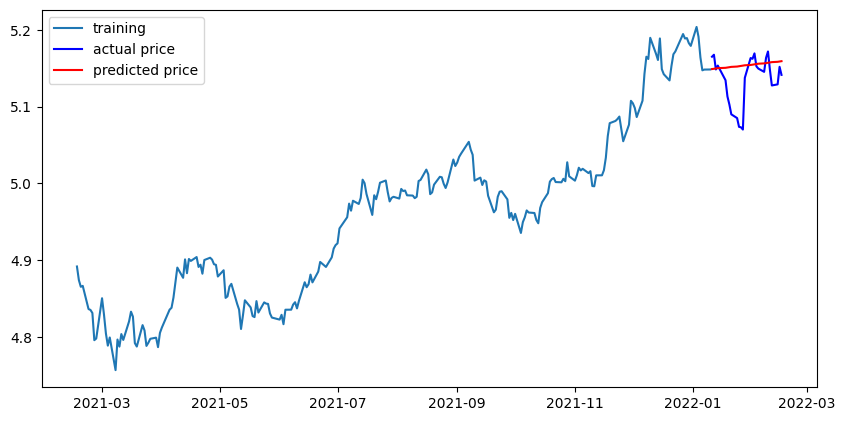

MSE:  38.71240100627189
MAE:  4.527610718954335
RMSE:  6.221929042208043
MAPE: 2.75%


In [5]:
mf.result_gap(train_data, test_data, 1, 2, 0)

## &nbsp;&nbsp; 8-3 마이크로소프트 사의 주식 데이터 예측


정성적 그래프 분석


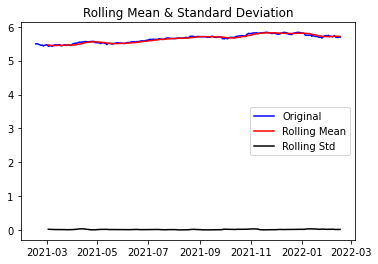

------------------------------
정량적 Augmented Dicky-Fuller Test
Results of Dickey-Fuller Test:
Test Statistic                  -1.323716
p-value                          0.618254
#Lags Used                       0.000000
Number of Observations Used    254.000000
Critical Value (1%)             -3.456360
Critical Value (5%)             -2.872987
Critical Value (10%)            -2.572870
dtype: float64
------------------------------
Results of Dickey-Fuller Test:
Test Statistic                  -4.923699
p-value                          0.000031
#Lags Used                       0.000000
Number of Observations Used    224.000000
Critical Value (1%)             -3.459885
Critical Value (5%)             -2.874531
Critical Value (10%)            -2.573694
dtype: float64
------------------------------


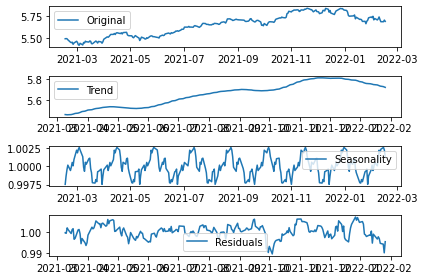

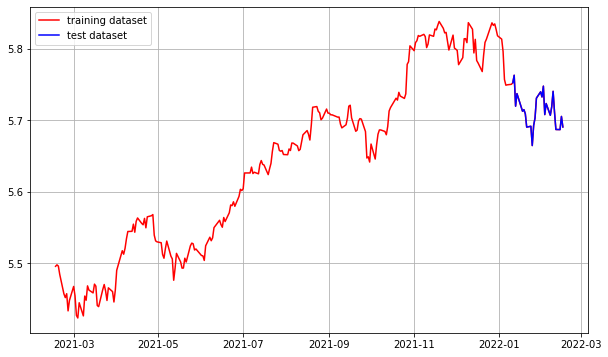

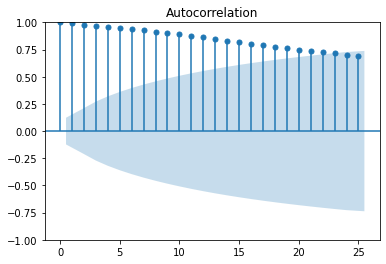

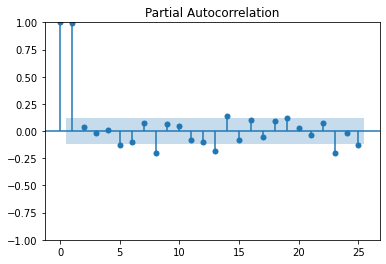

------------------------------
 1차 차분 구하기 
Results of Dickey-Fuller Test:
Test Statistic                -1.668969e+01
p-value                        1.492151e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.530000e+02
Critical Value (1%)           -3.456464e+00
Critical Value (5%)           -2.873033e+00
Critical Value (10%)          -2.572895e+00
dtype: float64
------------------------------
 2차 차분 구하기 
Results of Dickey-Fuller Test:
Test Statistic                -7.236970e+00
p-value                        1.928217e-10
#Lags Used                     1.400000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


In [6]:
train_data, test_data = mf.data_ready('MSFT')

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  229
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 614.341
Date:                Thu, 17 Feb 2022   AIC                          -1224.683
Time:                        08:20:37   BIC                          -1217.833
Sample:                             0   HQIC                         -1221.919
                                - 229                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4762      0.051     -9.400      0.000      -0.575      -0.377
sigma2         0.0003    2.7e-05      9.664      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   5.33   Jarque-

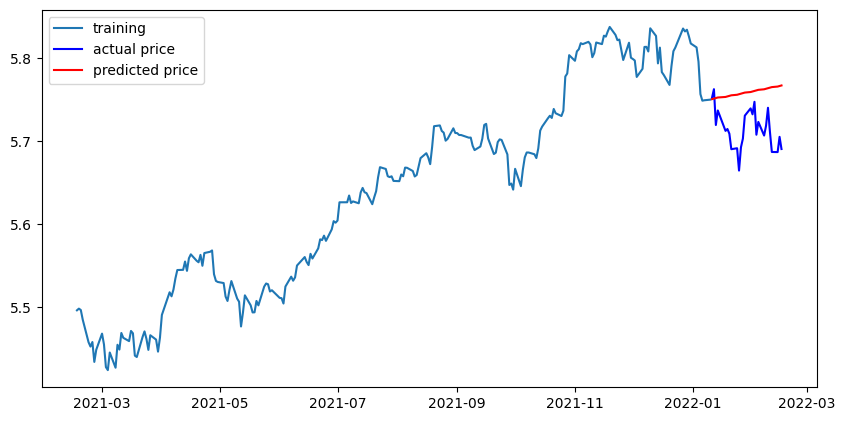

MSE:  246.9365789598795
MAE:  14.026076283937515
RMSE:  15.714215823892694
MAPE: 4.68%


In [7]:
mf.result_gap(train_data, test_data, 1, 2, 0)





----





# 회고! 

* 통계학 너무 어렵네요 정말 모르는 분야라 lms 내용을 들여다봐도 무슨 내용일까 한참 봤던것 같습니다... 평소엔 할 엄두도 나지않아 멀찍히 바라만 보고 있던 주식 데이터를 가져와, 예측을 해보긴 해봤는데.. 이게 잘 나온건지, 아니면 어느 부분이 잘못되서 개선이 필요한지를 확실히 몰랐던 점이 많이 답답했던점입니다. 


* 그래서 그런지 정확하게 예측하고 분석해서 잘 된 모델입니다! 라고 말 할 순 없지만, 이번 노드를 통해 배운건, 
    1. 시계열 데이터를 가져올 땐 그 데이터가 안정적인지, 불안정적인지 파악하고, 안정화 하는 과정을 해 줘야한다. (로그함수의 중요성) 
    2. ARIMA 모델을 통해 시계열 데이터를 가공해 줄 수 있다.
    3. 무언가를 판단하고 예측하기위해선, 우선 급변하는 부분을 없애주고, 일정한 패턴으로 가공 해 준 다음에 파악해야한다..?(?) 였던 것 같다.
    
* 몰랐던 귀무가설, 대립가설,P-VALUE 에 대한 이론도 간단하게 배웠다. 지금은 생소하지만, 앞으로 자주 보게 될 개념들이지 않을까? 그때가선 잘 부탁해?! 


* 이번 EXP에서 드디어! 전 과정 함수화를 시도해 볼 수 있었다! 함수에 기능을 하나하나 넣어 보면서 실행이 되는지, 안되는지를 체크하면서 함수에 추가해 주었다. 
    * 첫번째 함수를 제작할 땐, 처음부터 막혔었다. () 안에 파일 이름만 넣으면 파일을 불러와, 전처리 과정까지 되게끔 해 주고 싶었다. 하지만 실행 시 ('') 없이 넣어주다보니 자꾸 '파일이름' 변수가 없습니다! 라는 오류메세지를 만났다. 여러번 시도 해보던 끝에, `data_ready('MSFT')` 처럼 괄호 안에 문자열로 넣어주니 해결되었다. 정말 별거 아닌 문제로 한참을 씨름 했었다 😅
    * 두번째 함수를 구현하던 중, `name 'train_data' is not defined ` 라는 오류 메세지와 맞닥들이게 되었다. 첫번째 함수를 두번째 함수 안에 넣어주면 문제가 해결 될 줄 알고, 첫번째 함수 끝에 return을 붙여 test, train data를 반환할 수 있게 해 줬는데도 자꾸 없다고 떠, 제너레이터 함수를 써야하는건가..?! 라는 생각까지 했었다. 이번에도 안되겠군.. 하던 차, 준서님께서 도와주셔서 문제점이 어떤것이였는지를 해결 할 수 있었다. 
    * 첫번째 함수를 가져오면서, train과 test data를 함께 선언해 주면 두번째 함수에서도 사용 할 수 있었다. 이런 형태는 lms를 진행하면서 많이 봐왔던 형태였는데.. 일단 ``함수안에 함수를 넣으면 될 것이다`` 라는 생각에 사로잡혀 저렇게 사용할 생각을 못했던것같다. 이번에하면서 생각 안나서 헤맸으니, 다음번에 함수화 할 땐 생각나겠지! 소스도 주시고, 해결 방법도 알려주신 준서님, 정말정말 감사합니다:D!! 




----




# 🖇️ 참고 페이지

### my funtion 가져오기 

[Jupyter Notebook에서 다른 파일 Import 하는법](https://blog.naver.com/PostView.nhn?blogId=worb1605&logNo=221208281838)


### p,q,d 값이 이해 안되서 찾아본 좋은 사이트  
[ 비-계절성 ARIMA 모델 ](https://otexts.com/fppkr/non-seasonal-arima.html)